- https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/base.ipynb

### agent executor

- 即执行工具（`AgentAction`）的能力
- 即为 ReAct 即循环执行工具的能力

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai.chat_models import ChatOpenAI

In [5]:
tools = [TavilySearchResults(max_results=1)]

In [6]:
# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

In [9]:
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


#### agent state

- `input`: This is the input string representing the main ask from the user, passed in as input.
- `chat_history`: This is any previous conversation messages, also passed in as input.
- `intermediate_steps`: This is list of **actions and corresponding observations** that the agent takes over time. This is updated each iteration of the agent.
- `agent_outcome`: This is the response from the agent, either an `AgentAction or AgentFinish`. The AgentExecutor should finish when this is an AgentFinish, otherwise it should call the requested tools.

In [7]:
import operator
from typing import Annotated, TypedDict, Union

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

#### nodes、edges、graph

- a node can be either a function or a runnable:
    - input type is `AgentState`
    - The agent: responsible for deciding what (if any) actions to take.
    - A function to invoke tools: if the agent decides to take an action, this node will then execute that action.
- edges
    - normal edges
    - conditional edges

In [10]:
from langchain_core.agents import AgentFinish

from langgraph.prebuilt.tool_executor import ToolExecutor

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)


# Define the agent
def run_agent(state):
    agent_outcome = agent_runnable.invoke(state)
    return {"agent_outcome": agent_outcome}


# Define the function to execute tools
def execute_tools(state):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = state["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}


# Define logic that will be used to determine which conditional edge to go down
def should_continue(state):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(state["agent_outcome"], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

/tmp/ipykernel_3338036/50744384.py:7: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [11]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

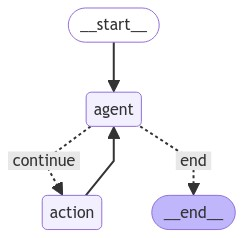

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
inputs = {"input": "what is the weather in sf", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-1106', 'system_fingerprint': 'fp_1867888df6'}, id='run-71137537-41db-4f1b-ab05-11d20d542542-0')])}
----
{'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in San Francisco'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_re